## Get Transcripts from YouTube Videos

In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi
import re

def get_youtube_transcripts(video_ids):
    """
    Fetches and concatenates transcripts from a list of YouTube video IDs.
    
    Args:
    video_ids (list): List of YouTube video IDs as strings.
    
    Returns:
    str: Concatenated transcript text.
    """
    transcript_text = ''
    for video_id in video_ids:
        try:
            # Fetch transcript
            transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
            # Concatenate transcript texts
            transcript_text += ' '.join([transcript['text'] for transcript in transcript_list]) + ' '
            transcript_text = transcript_text.lower()
        except Exception as e:
            print(f"Error fetching transcript for video ID {video_id}: {e}")
    
    
    return transcript_text


#List your youtube video ids from its URL:
video_ids = ['UfbyzK488Hk', 'uB0n4IZmS34']
transcripts = get_youtube_transcripts(video_ids)

In [ ]:
print(transcripts)

## Fix jargon and other things that get fouled up when youtube translates human speech

In [ ]:
databricks_variations = [
    r'\bdata breaks\b', r'\bdata bricks\b', r'\bdata brick\b', r'\bdata breakes\b', r'\bdata bri\b', r'\bdata brak\b', r'\bdata braks\b',
    r'\bdatabrick\b', r'\bdatabriks\b', r'\bdata briks\b', r'\bdata breakers\b', r'\bdata brakes\b', r'\bdatab bricks\b',
    r'\bdata brake\b', r'\bdata break\b', r'\bdatab briak\b', r'\bdatab briaks\b', r'\bdatab brick\b', r'\bdatab bricks\b',
    r'\bdata brecks\b', r'\bdata briak\b', r'\bdata brook\b', r'\bdata bir\b', r"\bdata burk's\b", r'\bdata brs\b'
]
for variation in databricks_variations:
    transcripts = re.sub(variation, 'Databricks', transcripts, flags=re.IGNORECASE)

In [ ]:
print(transcripts)

## Remove Stopwords, WordCloud Keyword Frequency

[nltk_data] Downloading package stopwords to /Users/eric/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/eric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


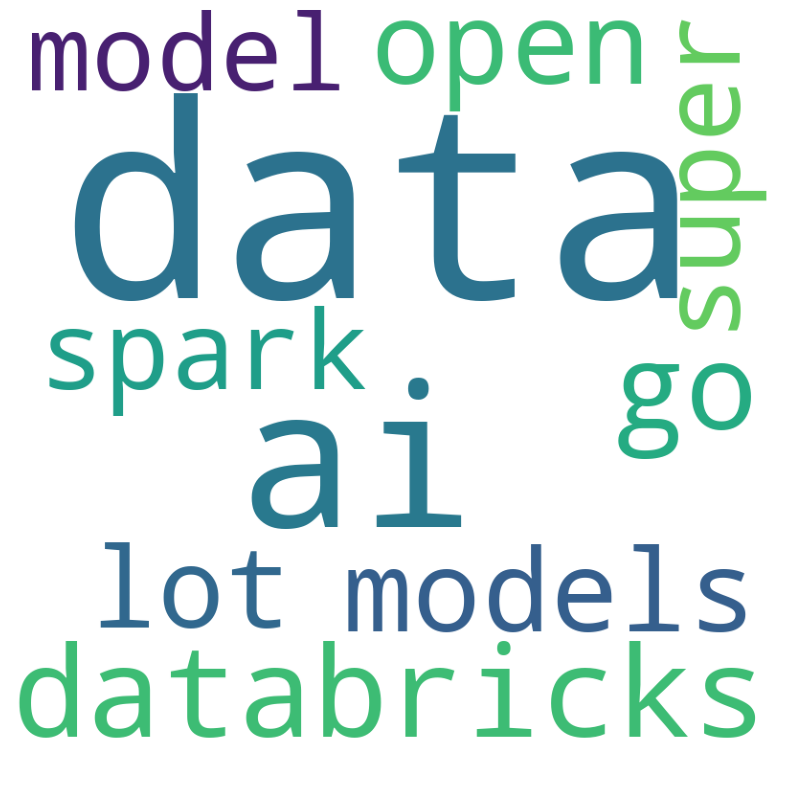

In [61]:
# Remove STOP WORDS like "at", "the" and "and" - then create a word cloud by frequency of key terms in the transcript
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Download dics of words
nltk.download('stopwords')
nltk.download('punkt')

# Tokenize
words = word_tokenize(transcripts)

# Filter out stop words and junk words
stop_words = set(stopwords.words('english'))
more_stop_words = ['use', 'well', 'azure', 'new', 'one', 'know', 'see', 'okay', 'got', 'make', 'actually', 'let', 'sort', 'yeah', 'able', 'need', 'going', 'show', 'take', \
                   'microsoft', 'thomas', 'aws', 'help', 'gon', 'na', 'back', 'us', 'um', 'uh', 'way', 'right', 'much', 'really', 'want', 'get', 'google', 'amazon', 'also', 'like' \
                   'thank', 'like', 'thank', 'great', 'including', 'using', 'applause', 'today', 'across', 'find']
all_stop_words = stop_words.union(more_stop_words)
keywords = [word.lower() for word in words if word.isalpha() and word.lower() not in all_stop_words]

# Calculate freq. dist. of the words remaining 'keywords'
freq_dist = nltk.FreqDist(keywords)

# Get the top N most common, after remove basic words, replace (N) w/ the TopN you want.
common_words = freq_dist.most_common(10)

# Create a string
word_freq = {word: freq for word, freq in common_words}

# WordCloud (WC)
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10)

# Generage the WC
wordcloud.generate_from_frequencies(word_freq)

# Plot and show the WC           
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.tight_layout(pad = 0)
plt.axis("off") 
plt.show()